<a href="https://colab.research.google.com/github/joshlensing/Coding-Dojo-Project-2/blob/main/Project_2_Baseball_Playoff_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseball Playoffs Predictions

I want to use baseball stats from baseball teams from 1962-2012 in order to predict whether teams will make the playoffs or not. I am a very big fan of baseball and have been since I was 8 years old. Baseball data and analytics are becoming a very big component of how professional baseball teams operate. A lot of this dataset comes from the idea of "Moneyball," where Billy Beane, the GM of the Oakland Athletics, found statisitics relating to individual player performance that scouts and other front offices were not focused on at the time. He hoped to use those background statistics and develop a formula for success that didn't require spending a large amount of money to build a roster of players. Instead, he hoped to find players that scored well in these statistical categories that other teams would often overlook and pay them cheaply to play for the Athletics. The hope was to ultimately make the playoffs and compete for a championship.

In [5]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import matplotlib as mpl

In [6]:
df = pd.read_csv('/content/baseball.csv')
df.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
0,ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,NaN,NaN,162,0.317,0.415
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,4.0,5.0,162,0.306,0.378
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,5.0,4.0,162,0.315,0.403
3,BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,NaN,NaN,162,0.331,0.428
4,CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,NaN,NaN,162,0.335,0.424


##Exploring and Cleaning the Data

###Get some information about the data

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Team          1232 non-null   object 
 1   League        1232 non-null   object 
 2   Year          1232 non-null   int64  
 3   RS            1232 non-null   int64  
 4   RA            1232 non-null   int64  
 5   W             1232 non-null   int64  
 6   OBP           1232 non-null   float64
 7   SLG           1232 non-null   float64
 8   BA            1232 non-null   float64
 9   Playoffs      1232 non-null   int64  
 10  RankSeason    244 non-null    float64
 11  RankPlayoffs  244 non-null    float64
 12  G             1232 non-null   int64  
 13  OOBP          420 non-null    float64
 14  OSLG          420 non-null    float64
dtypes: float64(7), int64(6), object(2)
memory usage: 144.5+ KB


Based on the dtypes from the information about the data, it appears that all of the columns in the dataset match the data dictionary. There also appear to be quite a few missing data values from a couple of columns. Overall there are 1,232 rows and 15 columns.

In [8]:
df.shape

(1232, 15)

### Check for duplicated rows

In [9]:
df.duplicated().sum()

0

There are 0 duplicated rows. Next I want to look at the missing values more closely and see what I am working with for modeling.

### Checking for missing values

In [10]:
df.isna().sum()

Team              0
League            0
Year              0
RS                0
RA                0
W                 0
OBP               0
SLG               0
BA                0
Playoffs          0
RankSeason      988
RankPlayoffs    988
G                 0
OOBP            812
OSLG            812
dtype: int64

I'll also look at the percentages of the missing value columns to beter understand how much data I'm actually missing.

In [11]:
df.isna().sum()/len(df)*100

Team             0.000000
League           0.000000
Year             0.000000
RS               0.000000
RA               0.000000
W                0.000000
OBP              0.000000
SLG              0.000000
BA               0.000000
Playoffs         0.000000
RankSeason      80.194805
RankPlayoffs    80.194805
G                0.000000
OOBP            65.909091
OSLG            65.909091
dtype: float64

Looking at the data and understanding what each column means to the dataset, I am going to drop 2 of the rows. 'RankSeason' and 'RankPlayoff' are not necessary to predicting whether or not the team is going to make the playoffs. The column gives the seed rank of the team that makes the playoffs. 'RankPlayoff' is exclusive to those teams that make the playoffs, so it would act as a cheating tool for the training and testing sets in modeling. 'RankSeason' seems to do the same thing as 'RankPlayoff', so it will be dropped as well.

The missing data in 'OOBP' and 'OSLG' will not be replaced for data exploration, but it will not be dropped for modeling either. These columns look at opponent on-base and slugging percentage, so they could still be useful in the predictions.

In [12]:
df = df.drop(columns=['RankSeason', 'RankPlayoffs'])
df.columns

Index(['Team', 'League', 'Year', 'RS', 'RA', 'W', 'OBP', 'SLG', 'BA',
       'Playoffs', 'G', 'OOBP', 'OSLG'],
      dtype='object')

###Checking for consistency in the data

I will first check the categorical and numerical values for consistency and potential impossible numerical values.

In [13]:
# checking categorical data
print(df['Team'].value_counts())
print(df['League'].value_counts())

HOU    47
DET    47
NYY    47
NYM    47
MIN    47
LAD    47
SFG    47
PIT    47
PHI    47
STL    47
CLE    47
CIN    47
CHW    47
CHC    47
BOS    47
BAL    47
ATL    43
OAK    41
KCR    40
SDP    40
MIL    39
TEX    37
TOR    33
SEA    33
MON    32
CAL    28
COL    18
FLA    17
ARI    15
LAA    11
TBD    10
WSA    10
WSN     8
ANA     8
KCA     6
TBR     5
MLN     4
MIA     1
SEP     1
Name: Team, dtype: int64
NL    616
AL    616
Name: League, dtype: int64


There are 30 teams in MLB currently, but there appear to be more than that in this dataset. I will double check this now without counting them individually.

In [14]:
df['Team'].nunique()

39

There are teams that have gone by different names over the 50 years of the dataset, so some teams will be represented by different names as the years went on.

___

After checking the categorical data values, now I will check the numerical values and check for any impossible numbers in the dataset.

In [15]:
# checking the numerical values
df.describe(include='number')

,Year,RS,RA,W,OBP,SLG,BA,Playoffs,G,OOBP,OSLG
count,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,420.000000,420.000000
mean,1988.957792,715.081981,715.081981,80.904221,0.326331,0.397342,0.259273,0.198052,161.918831,0.332264,0.419743
std,14.819625,91.534294,93.079933,11.458139,0.015013,0.033267,0.012907,0.398693,0.624365,0.015295,0.026510
min,1962.000000,463.000000,472.000000,40.000000,0.277000,0.301000,0.214000,0.000000,158.000000,0.294000,0.346000
25%,1976.750000,652.000000,649.750000,73.000000,0.317000,0.375000,0.251000,0.000000,162.000000,0.321000,0.401000
50%,1989.000000,711.000000,709.000000,81.000000,0.326000,0.396000,0.260000,0.000000,162.000000,0.331000,0.419000
75%,2002.000000,775.000000,774.250000,89.000000,0.337000,0.421000,0.268000,0.000000,162.000000,0.343000,0.438000
max,2012.000000,1009.000000,1103.000000,116.000000,0.373000,0.491000,0.294000,1.000000,165.000000,0.384000,0.499000


All of the numerical values look good, so now I will move on to the data exploratory analysis.

## Exploratory Data Analysis

### Univariate Visuals of Target Data and Features

To gain a better understanding of the target and features of my data,  I can visualize each of them to know how the values in each column compare. Histograms are a great way to compare the values in the rows of a dataset and are fairly easy to understand how much of each value exists. To do this, I will create a function that allows me plot the same histogram for each column, then I will loop through the columns in order to create visuals for each one.

In [16]:
def plot_dist(data, x, figsize = (12,6)):

  fig, ax = plt.subplots(figsize = figsize)
  ## Plot histogram
  sns.histplot(data = data, x = x, ax = ax)
  plt.xticks(rotation=45)

  return fig, ax

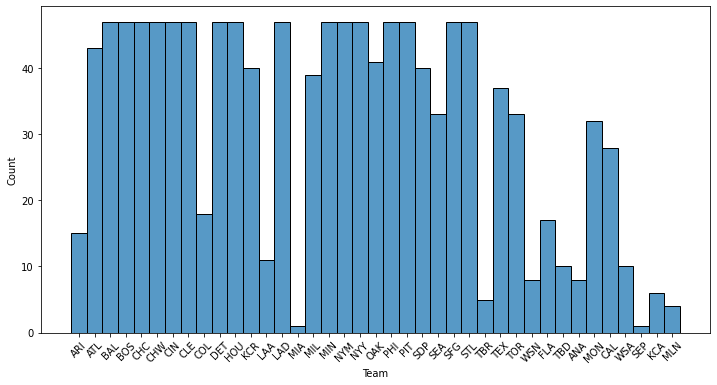

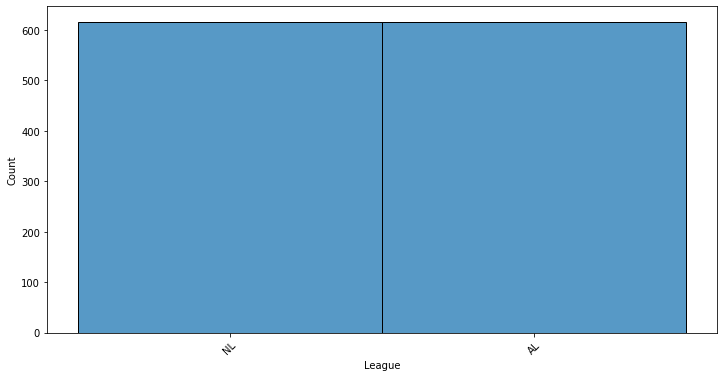

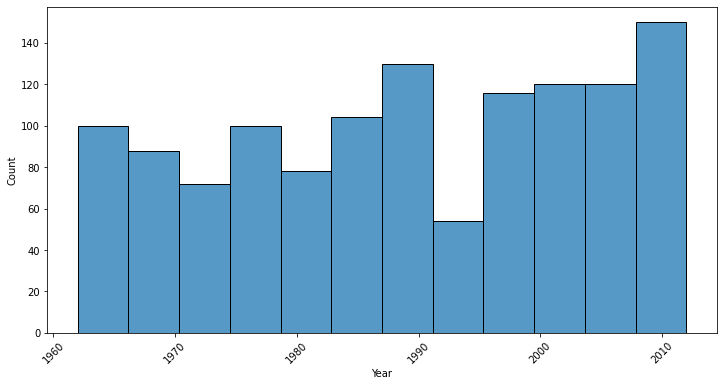

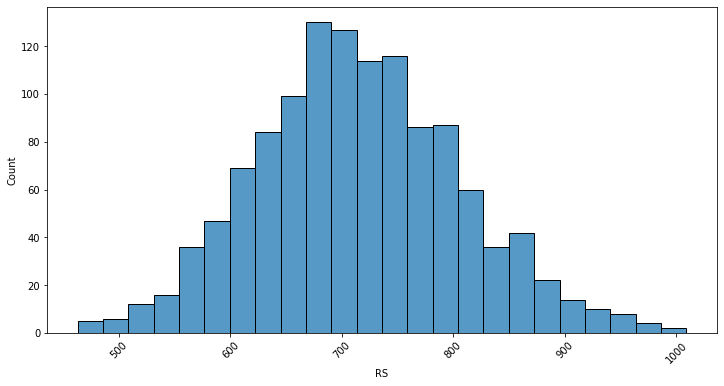

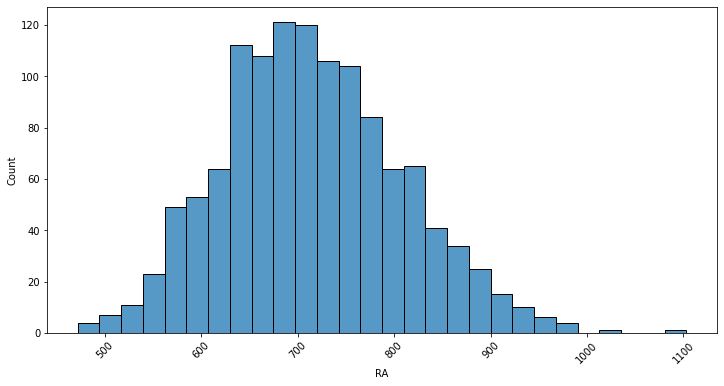

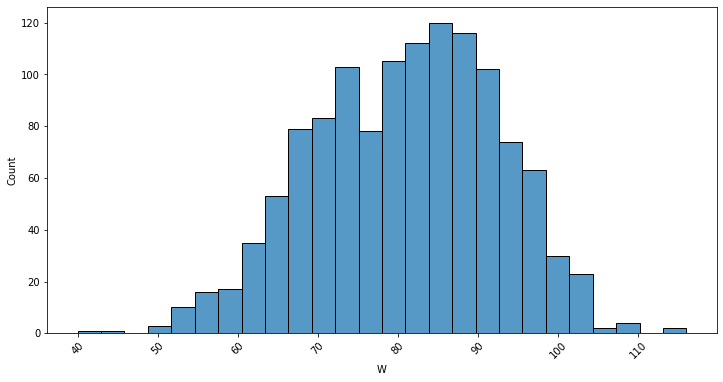

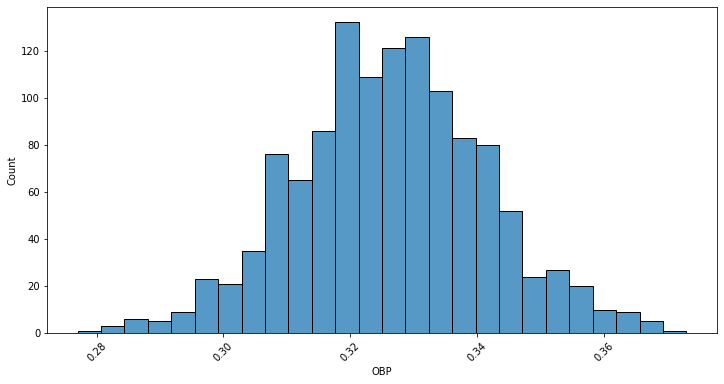

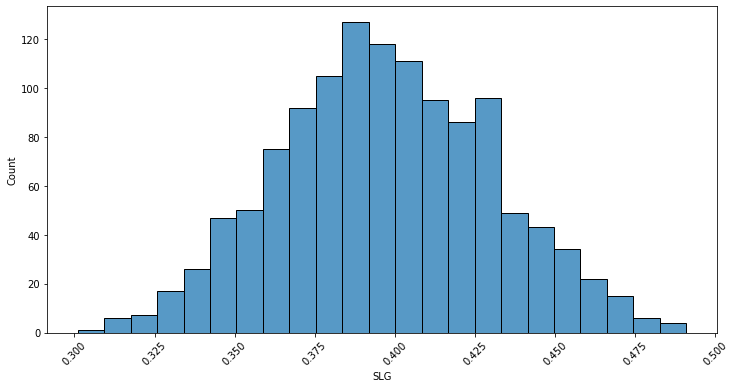

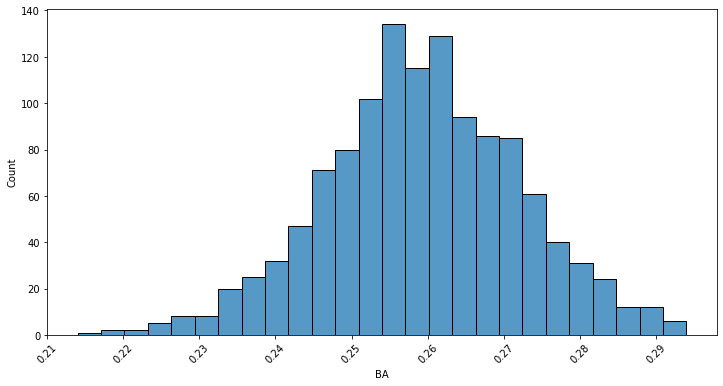

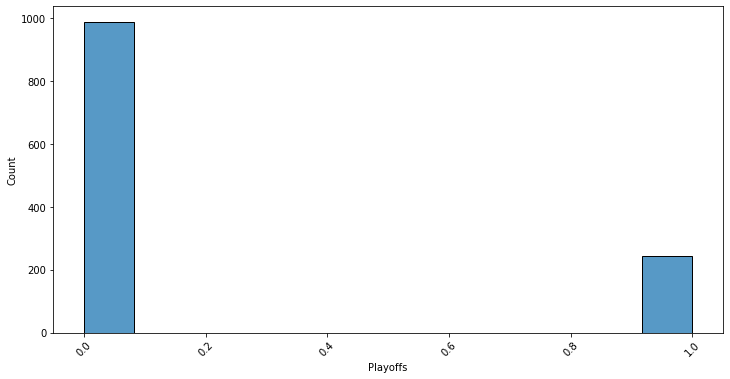

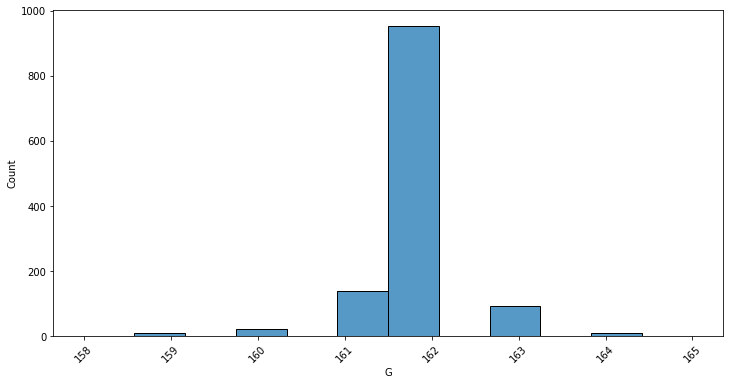

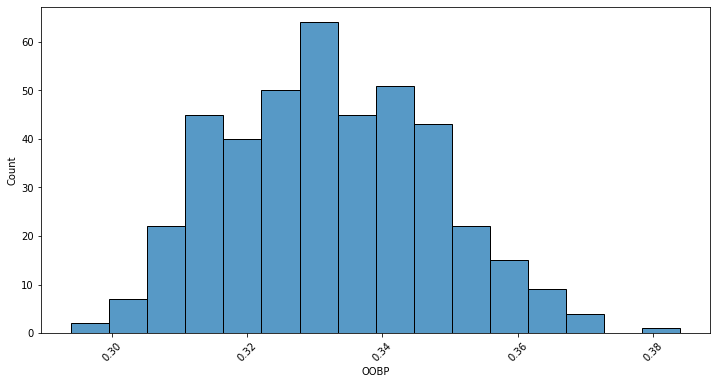

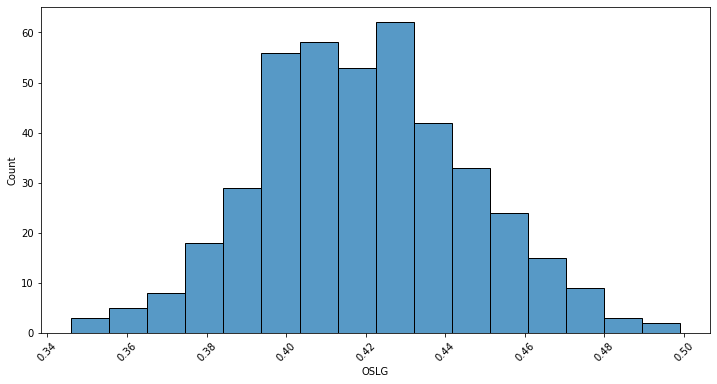

In [17]:
cols = df.columns
for col in cols:
  fig, ax = plot_dist(df, col)

### Visualizing Outliers

The best method to visualizing outliers is through the use of a boxplot. As with the histograms in the previous section, I will create a function for the boxplots and loop through the numeric columns in order to visualize the outliers for each column.

In [18]:
# creating a function for the boxplots
def box_plot(data, x, y, figsize = (10,5)):

  fig, ax = plt.subplots(figsize = figsize)
  ## Plot boxplot
  sns.boxplot(data = data, x = x, y = y, notch=True)

  return fig, ax

In [19]:
dtypes = df.dtypes
box_cols1 = dtypes[dtypes == 'int'].index
box_cols1

Index(['Year', 'RS', 'RA', 'W', 'Playoffs', 'G'], dtype='object')

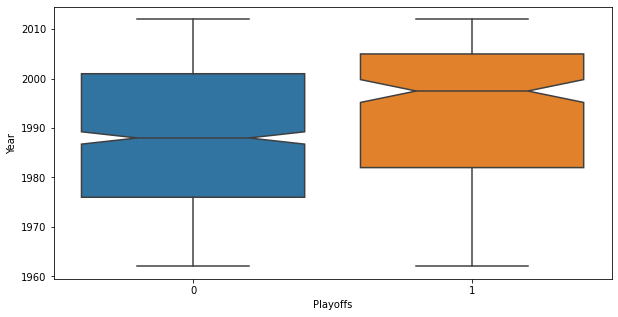

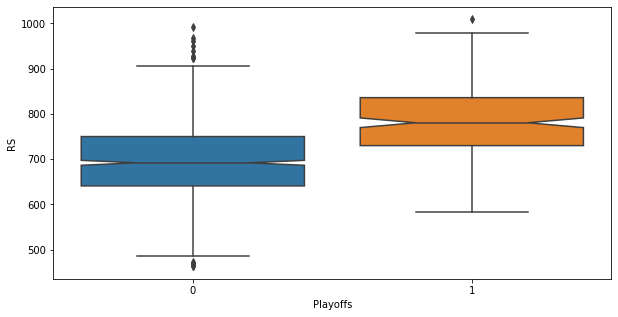

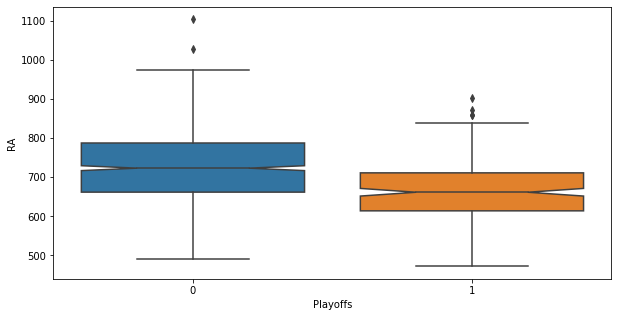

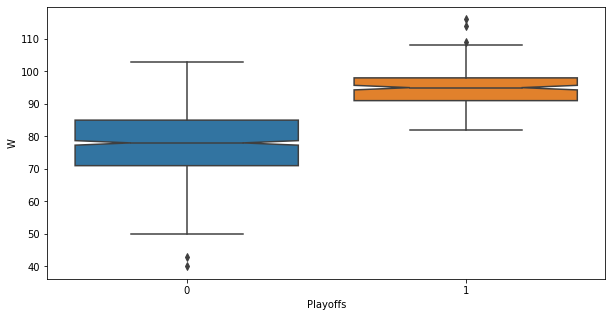

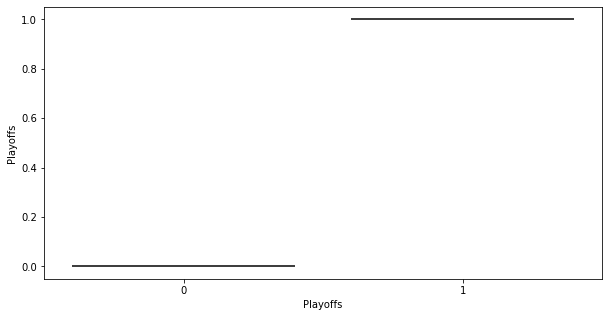

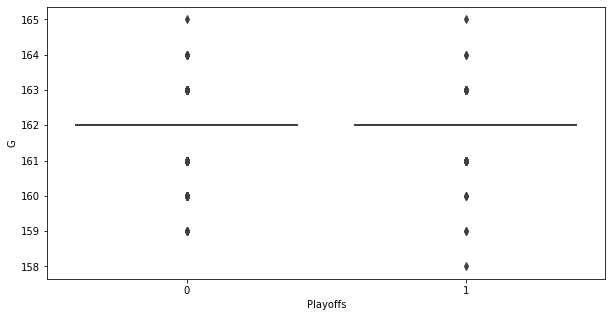

In [20]:
# creating a loop for the integer boxplots
for col in box_cols1:
  box_plot(df, 'Playoffs', col)

In [21]:
# float columns will also need to have boxplots
box_cols2 = dtypes[dtypes == 'float'].index
box_cols2

Index(['OBP', 'SLG', 'BA', 'OOBP', 'OSLG'], dtype='object')

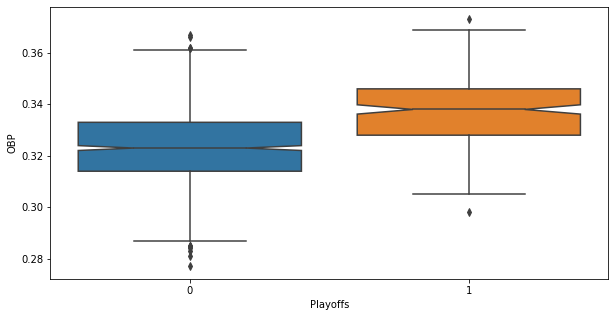

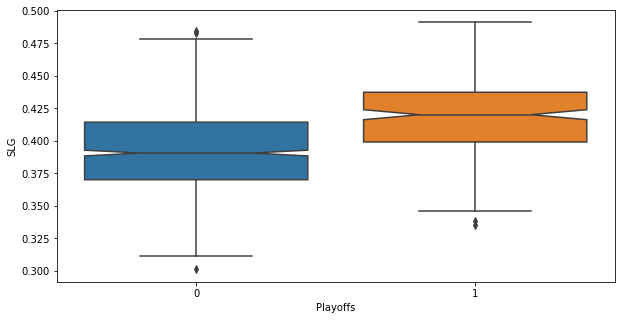

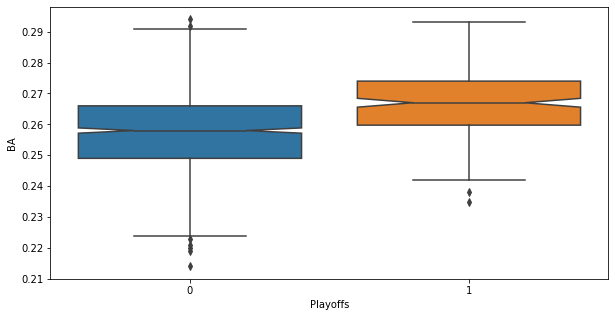

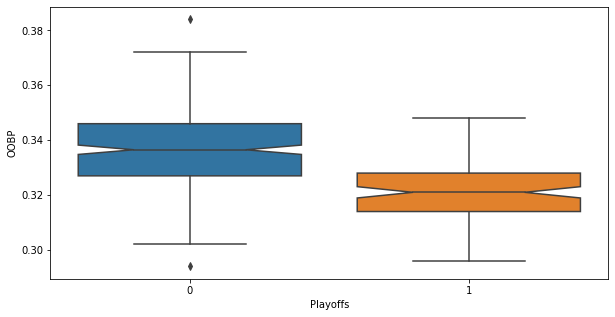

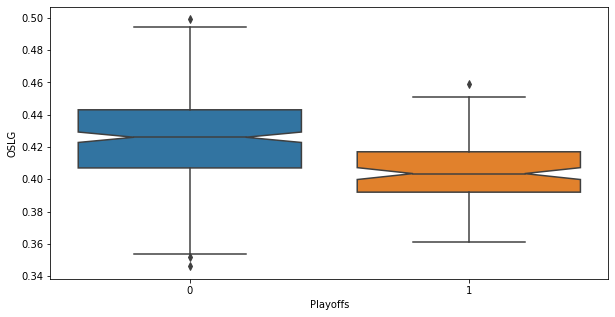

In [22]:
# creating a loop for the boxplots
for col in box_cols2:
  box_plot(df, 'Playoffs', col)

OBP, SLG, BA, OOBP, OSLG all have outliers in the dataset, although there are very few. RS, RA, and W all had outliers as well in the integer columns. G had outliers as well, although that is because most of the seasons had a certain number of games played, while others had played fewer, either due to a work stoppage or a schedule expansion in more recent years.

##Explanatory Data Analysis

### Correlation Heat Map

In order to find features that correlate with one another, or potentially have correlation with the target, I will create a heat map that shows the magnitude of correlation between columns. Any positive or negative correlation of 0.5 or -0.5 or greater (or less than in the case of the negative) then I can create a visual to show the relationship.

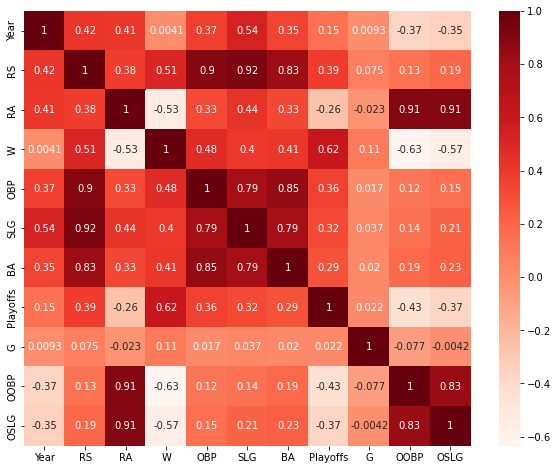

In [23]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(corr, cmap = 'Reds', annot = True);

The heatmap shows a lot of correlation between data points, some very substantial. The idea of Moneyball heavily revolves around getting runners on base in order to score runs. In the heatmap, the correlation of OBP and runs is 0.9, a staggering number. From there, I can look at the RS (runs scored) and W (wins) in a visual as well since the correlation between those values is 0.51. Other strong correlations include BA, OBP, and SLG, which makes sense that as one goes higher, the others tend to follow based on how those stats are affected with success during an at-bat.

Soruce for adjusting heatmap size: https://stackoverflow.com/questions/38913965/make-the-size-of-a-heatmap-bigger-with-seaborn

###Visualizing Average Number of Wins per Team

The number of wins dictates which teams make the playoffs and which don't. The number varies from year to year, depending on the performance of teams in certain divisions. One thing that will be helpful to visualize will be to see the most successful teams over the 50 year period from 1962-2012. To do this, I will see the average number of wins per team in the dataset and plot them in a barplot.

In [24]:
avg_wins = df.groupby(['Team'])['W'].mean().sort_values(ascending=False)
avg_wins

Team
TBR    91.600000
NYY    90.255319
LAA    88.000000
LAD    86.489362
MLN    86.000000
BOS    85.893617
STL    85.723404
SFG    84.574468
OAK    84.097561
CIN    84.021277
ATL    83.395349
BAL    83.361702
ANA    83.000000
PHI    82.319149
MIN    81.723404
CHW    81.659574
TOR    81.212121
ARI    80.666667
DET    80.276596
TEX    79.945946
PIT    79.489362
HOU    78.978723
CAL    78.178571
MIL    77.846154
MON    77.656250
CLE    77.489362
FLA    77.470588
CHC    77.425532
NYM    77.382979
KCR    77.325000
COL    76.166667
SDP    75.725000
SEA    75.515152
WSN    73.750000
MIA    69.000000
WSA    67.900000
KCA    66.166667
TBD    64.500000
SEP    64.000000
Name: W, dtype: float64

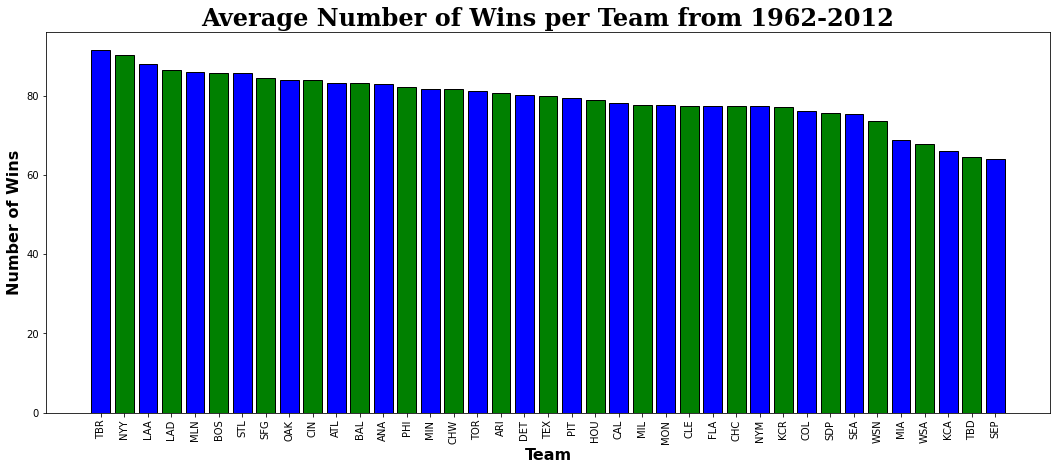

In [105]:
# plotting with a barplot
with plt.style.context('seaborn-dark-palette'): 
  fig, ax = plt.subplots(figsize = (18,7))
  plt.bar(avg_wins.index, avg_wins.values, color=['blue', 'green'], edgecolor='black');
  plt.xlabel('Team', fontsize=16, fontweight='bold')
  plt.ylabel('Number of Wins', fontsize=16, fontweight='bold')
  plt.title('Average Number of Wins per Team from 1962-2012', fontsize=24, fontweight='black', fontfamily='serif')
  plt.xticks(rotation = 90);

TBR, or the Tampa Bay Rays, have the highest average number of wins during the 50 year period. This graph is really useful in seeing the teams that have had the highest level of success. The Athletics are in the top 10 of teams in wins, so their formula for success seems to have helped their season to season performance.


###Relationship Between Wins and OBP

Next, I want to see the distribution of wins and OBP and see what plots lead to a playoff spot. I can achieve this by creating a scatterplot and plotting the wins on the x-axis and OBP on the y-axis. This will give me a good idea of how well a higher OBP leads to team wins.

In [26]:
# filtering the dataset for last 25 years
obp_df = df[df['Year'] > 1987]
obp_df

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,G,OOBP,OSLG
0,ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,162,0.317,0.415
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,162,0.306,0.378
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,162,0.315,0.403
3,BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,162,0.331,0.428
4,CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,162,0.335,0.424
...,...,...,...,...,...,...,...,...,...,...,...,...,...
659,SEA,AL,1988,664,744,68,0.317,0.398,0.257,0,161,NaN,NaN
660,SFG,NL,1988,670,626,83,0.318,0.368,0.248,0,162,NaN,NaN
661,STL,NL,1988,578,633,76,0.309,0.337,0.249,0,162,NaN,NaN
662,TEX,AL,1988,637,735,70,0.320,0.368,0.252,0,161,NaN,NaN


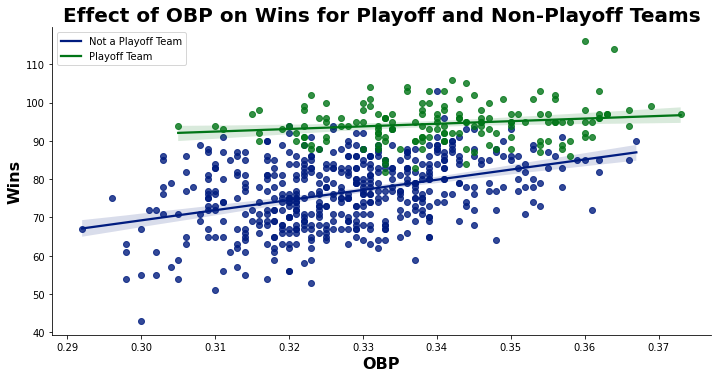

In [27]:
# creating the plot with Seaborn
with plt.style.context('seaborn-dark-palette'):
  g = sns.lmplot(data=obp_df, x='OBP', y='W', hue='Playoffs', legend=False, aspect=2)
  plt.xlabel('OBP', fontsize=16, fontweight='bold')
  plt.ylabel('Wins', fontsize=16, fontweight='bold')
  plt.title('Effect of OBP on Wins for Playoff and Non-Playoff Teams',
            fontsize=20,
            fontweight='black')
  plt.legend(loc='upper left', labels=['Not a Playoff Team', 'Playoff Team']);

For teams over the last 25 years of the dataset, it looks like the OBP gave teams a better chance of winning more games. The datapoints for the playoff and non-playoff teams both showed trends with having more wins with a higher OBP, although a higher OBP did not seem to play as much as a role in playoff teams compared to the non-playoff teams.

Source for changing legend labels: https://stackoverflow.com/questions/45201514/how-to-edit-a-seaborn-legend-title-and-labels-for-figure-level-functions

###Relationship Between Runs Scored and OBP

Another relationship I want to visualize is the strong correlation between runs scored and OBP. I will be making a regplot to plot the datapoints.

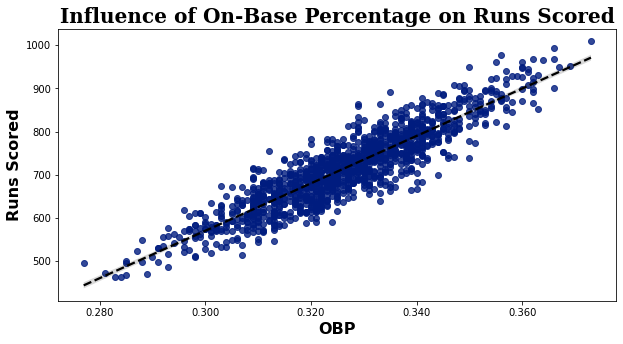

In [28]:
# creating the plot with Seaborn
obp_fmt = mpl.ticker.StrMethodFormatter('{x:.3f}')
with plt.style.context('seaborn-dark-palette'):
  fig, ax = plt.subplots(figsize = (10,5))
  sns.regplot(data=df, x='OBP', y='RS',
              line_kws={'color': 'black', 'ls': '--'})
  plt.xlabel('OBP', fontsize=16, fontweight='bold')
  plt.ylabel('Runs Scored', fontsize=16, fontweight='bold')
  plt.title('Influence of On-Base Percentage on Runs Scored',
            fontsize=20,
            fontweight='black',
            fontfamily='serif')
  ax.xaxis.set_major_formatter(obp_fmt)

  plt.show()

The amount of runs scored goes up as OBP gets larger. As more runners are on base, the likelihood of scoring runs goes up, which also could lead to more team wins.

Source for x-axis formatting: https://matplotlib.org/stable/gallery/ticks/dollar_ticks.html

###Visualizing the Effect of Opponent OBP on Wins

The inverse of the regplot above can also be visualized. OOBP calculates the opponent on base percentage, but I will plot the datapoints against wins to show that relationship.

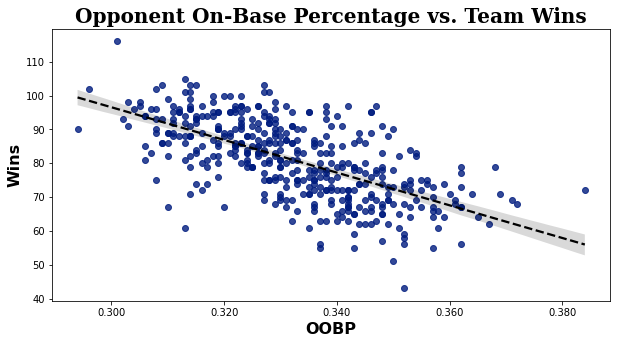

In [29]:
# creating the plot with Seaborn
obp_fmt = mpl.ticker.StrMethodFormatter('{x:.3f}')
with plt.style.context('seaborn-dark-palette'):
  fig, ax = plt.subplots(figsize = (10,5))
  sns.regplot(data=df, x='OOBP', y='W',
              line_kws={'color': 'black', 'ls': '--'})
  plt.xlabel('OOBP', fontsize=16, fontweight='bold')
  plt.ylabel('Wins', fontsize=16, fontweight='bold')
  plt.title('Opponent On-Base Percentage vs. Team Wins',
            fontsize=20,
            fontweight='black',
            fontfamily='serif')
  ax.xaxis.set_major_formatter(obp_fmt)

  plt.show()

As the on-base percentage for the opponents increases, the chances of winning the game goes down. Giving the opposing team more scoring opportunities seems to lead to a greater chance of losing games.

# Model Predictions with Machine Learning

Up to this point I have been cleaning and exploring the data, viewing how values in columns influence and have relationships with others. At this point, I want to use the dataset and run the it through various models in order predict whether or not a team makes the playoffs with the data given.

The problem of whether or not a team will make the playoffs is a classification problem, so the models I will be using will be specific to classification. In this case, my predictions will binary, as there are only 2 options that teams have: make the playoffs or not. The models I will be choosing will be Logsitic Regression, Random Forest, and XGBoost. Logisitic Regression works very well on a dataset with fewer features such as this one, and works very quickly in making its predictions. Random Forest usually has high rates of success in predictions and helps lower the variance of predictions. And XGBoost is used for all kinds of datasets with usually high success.

**Note**:

I will save a copy of the dataset in order to perform machine learning as to preserve the dataset that was used to explore in the previous section.

In [30]:
ml_df = df.copy()

In [31]:
ml_df.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,G,OOBP,OSLG
0,ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,162,0.317,0.415
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,162,0.306,0.378
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,162,0.315,0.403
3,BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,162,0.331,0.428
4,CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,162,0.335,0.424


###Imports

In [32]:
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import make_pipeline as make_sampler_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (ConfusionMatrixDisplay, 
                             RocCurveDisplay, 
                             classification_report)
from sklearn import set_config
set_config(display='diagram')

###Metric Evaluation Function

I will create a function that will allow me to input the predictions from each model and create an evaluation of the metrics for each one. This helps save time and code so that the evaluations can be done in one simple line of code.

In [33]:
def evaluate_classification(model, X_test, y_test, label='Test Data', 
                             figsize=(15,5), normalize='true',
                             cmap='Greens'): 
                             
    fig, axes = plt.subplots(1,2, figsize=figsize)

    ## Get Predictions
    y_pred = model.predict(X_test)
     
   ## Print classification report for the test data (and make it pretty!)
    print('---'*20)
    print(f"[i] CLASSIFICATION REPORT FOR: {label}")
    print('---'*20)

    print(classification_report(y_test, y_pred))

    ConfusionMatrixDisplay.from_predictions(y_test,y_pred, 
                normalize=normalize, cmap=cmap,              
                ax=axes[0])    
    
    RocCurveDisplay.from_estimator(model, X_test, y_test,
                                   ax=axes[1])
    plt.show()

##Checking the for Class Imbalance

In [34]:
ml_df['Playoffs'].value_counts()

0    988
1    244
Name: Playoffs, dtype: int64

The data is pretty imbalanced in the target column. This makes sense as the data is looking at every team in the league and then showing us which teams make the playoffs, which is a smaller total than the total number of teams in the league. This needs to be heavily considered when using the models to make predictions.

## Model #1: Logistic Regression

With all data cleaning completed, I can jump right in a begin to prepare the data for preprocessing in order to fit the training data on the model.

##Preprocessing

###Train Test Split

In [35]:
# Assign features and target of the dataset
X = ml_df.drop(columns=['Playoffs', 'OOBP', 'OSLG'])
y = ml_df['Playoffs']
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

###Creating the Column Transformer

In [36]:
# Instantiate the transformers
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
# Create ColumnSelectors for the the numeric and categorical data
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')
# Combine the Pipelines and ColumnSelectors into tuples for the ColumnTransformer
cat_tuple = (ohe, cat_selector)
num_tuple = (scaler, num_selector)
# Create the preprocessing ColumnTransformer
preprocessor = make_column_transformer(cat_tuple, num_tuple, remainder='drop')
preprocessor

ColumnTransformer(transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fcef0d71c40>),
                                ('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fcef0d71280>)])

**Note**: There was a substantial amount of missing data of about 66% in the 'OOBP' and 'OSLG' columns which gives information about opposing teams on-base and slugging percentages. 'RA', or runs allowed, also gives me some useful insight into how opposing teams did against a particular team, so those columns will be dropped for machine learning.

###Instantiate Model and Fit on the Data

In [37]:
# Make a logistic regression instance
lr = LogisticRegression()
# Make a pipeline for the model with the preprocessor
lr_pipe = make_pipeline(preprocessor, lr)
# Fit the pipeline on the training data
lr_pipe.fit(X_train, y_train)
# Make the predictions
lr_train_preds = lr_pipe.predict(X_train)
lr_test_preds = lr_pipe.predict(X_test)

###Metric Evaluation on Model without Parameter Tuning

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       247
           1       0.75      0.69      0.72        61

    accuracy                           0.89       308
   macro avg       0.84      0.82      0.83       308
weighted avg       0.89      0.89      0.89       308



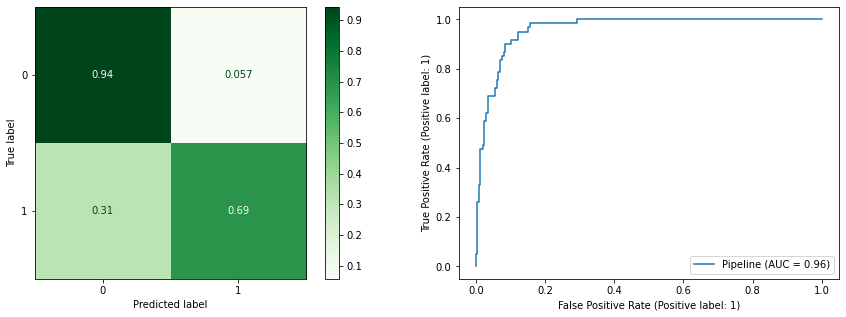

In [38]:
evaluate_classification(lr_pipe, X_test, y_test, label = 'Test Data')

The accuracy score for the testing data was 0.89 for the model without tuning it. The model was best at predicting teams that did not make the playoffs, as evidenced by the high precision score, but was not so good at predicting teams that do make the playoffs with a recall score of only 0.69. In the case of this dataset, the recall score will be important to raise as I want to make good predictions of which teams do make the playoffs.

###Tuning the Parameters

In [39]:
# finding the parameters of the model to tune
lr_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fcef0d71c40>),
                                   ('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fcef0d71280>)])),
  ('logisticregression', LogisticRegression())],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fcef0d71c40>),
                                 ('standar

In [40]:
# Creating lists of other possible values for parameters
lr_param_grid = {'logisticregression__class_weight': ['balanced', None],
              'logisticregression__C': [.001, .01, 1, 10],
              'logisticregression__max_iter': [50, 60, 70, 80],
              'logisticregression__penalty': ['l1','l2'],
              'logisticregression__solver': ['liblinear']}

In [41]:
# Making a pipeline with GridSearchCV
lr_dt_grid_search = GridSearchCV(lr_pipe, lr_param_grid)

In [42]:
# Fit the pipeline on the training data
lr_dt_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fcef0d71c40>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fcef0d71280>)])),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [0.001, 0.01, 1, 10],
                         'logisticregression__class_weight': ['balanced', None],
                         'logisticregression__max_iter': [50, 60, 70, 80],
                         'logisticregression__penalty': ['l1', 'l2'],
                         'logisticregression__solver': ['liblinear']})

In [43]:
# Finding the best tuned parameters
lr_dt_grid_search.best_params_

{'logisticregression__C': 1,
 'logisticregression__class_weight': None,
 'logisticregression__max_iter': 50,
 'logisticregression__penalty': 'l1',
 'logisticregression__solver': 'liblinear'}

In [44]:
# Instantiate the tuned model
best_log_model = lr_dt_grid_search.best_estimator_
# Fit the model on the training data
best_log_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fcef01989a0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fcef01981c0>)])),
                ('logisticregression',
                 LogisticRegression(C=1, max_iter=50, penalty='l1',
                                    solver='liblinear'))])

###Metric Evaluation of Tuned Model

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Testing Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       247
           1       0.76      0.72      0.74        61

    accuracy                           0.90       308
   macro avg       0.85      0.83      0.84       308
weighted avg       0.90      0.90      0.90       308



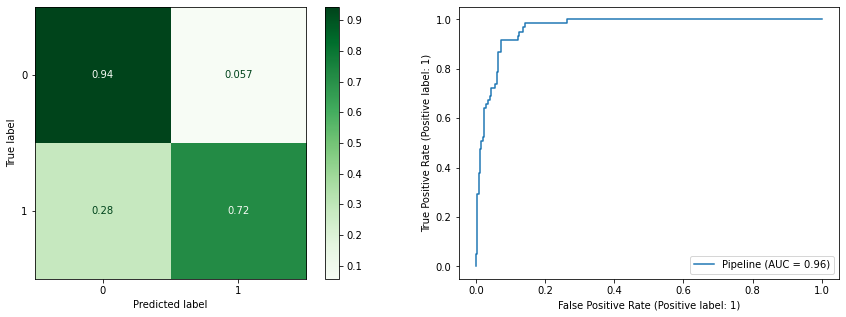

In [45]:
evaluate_classification(best_log_model, X_test, y_test, label='Testing Data')

###Dealing with Class Imbalance

As I found before implementing the models, I noticed that there was a significant imbalace in the values of the target column. In order to help my model and improve the recall score, I will use the help of SMOTE, which creates synthetic data in order to balance the values of the class. In this instance, it will create rows that have playoff teams in order to help the model better make predictions.

In [46]:
# Creating a model pipeline with SMOTE, the model, and preprocessor
smote = SMOTE()
lr_smote = LogisticRegression()
lr_smote_pipe = make_sampler_pipeline(preprocessor, smote, lr_smote)
# Fit the model on the training data
lr_smote_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fcef0d71c40>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fcef0d71280>)])),
                ('smote', SMOTE()),
                ('logisticregression', LogisticRegression())])

###SMOTE Model Metric Evaluation

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Testing Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       247
           1       0.71      0.90      0.79        61

    accuracy                           0.91       308
   macro avg       0.84      0.90      0.87       308
weighted avg       0.92      0.91      0.91       308



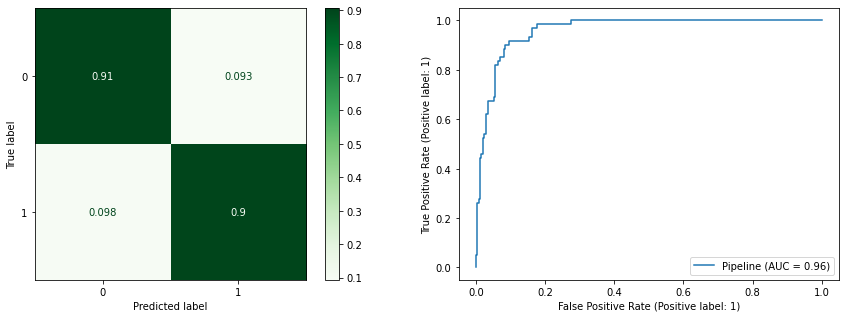

In [47]:
evaluate_classification(lr_smote_pipe, X_test, y_test, label='Testing Data')

The recall score for the playoff teams significantly increased, so now I will tune the parameters to see if the score can be increased further.

###Parameter Tuning of the Model

In [48]:
# finding the parameters of the model to tune
lr_smote_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fcef0d71c40>),
                                   ('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fcef0d71280>)])),
  ('smote', SMOTE()),
  ('logisticregression', LogisticRegression())],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fcef0d71c40>),
                    

In [49]:
# Creating lists of other possible values for parameters
param_grid = {'logisticregression__class_weight': ['balanced', None],
              'logisticregression__C': [.001, .01, 1, 10],
              'logisticregression__max_iter': [50, 60, 70, 80],
              'logisticregression__penalty': ['l1','l2'],
              'logisticregression__solver': ['liblinear']}

In [50]:
# Making a pipeline with GridSearchCV
dt_grid_search = GridSearchCV(lr_smote_pipe, param_grid)

In [51]:
# Fit the pipeline on the training data
dt_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fcef0d71c40>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fcef0d71280>)])),
                                       ('smote', SMOTE()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [0.001, 0.01, 1, 10],
                         'logisticregression__class_weight': ['balanced', None],
                         'logisticregression__max_iter': [50, 60, 70, 80],
                         'logisticregression__penalty': ['l1', 'l2'],
                         'logisticregression__solver': ['liblinear']})

In [52]:
# Finding the best tuned parameters
dt_grid_search.best_params_

{'logisticregression__C': 10,
 'logisticregression__class_weight': None,
 'logisticregression__max_iter': 70,
 'logisticregression__penalty': 'l1',
 'logisticregression__solver': 'liblinear'}

In [53]:
# Instantiate the tuned model
best_lr_model = dt_grid_search.best_estimator_
# Fit the model on the training data
best_lr_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fcef0db2550>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fcef0db2e80>)])),
                ('smote', SMOTE()),
                ('logisticregression',
                 LogisticRegression(C=10, max_iter=70, penalty='l1',
                                    solver='liblinear'))])

###Metric Evaluation on Model with Parameter Tuning

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Testing Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       247
           1       0.69      0.82      0.75        61

    accuracy                           0.89       308
   macro avg       0.82      0.87      0.84       308
weighted avg       0.90      0.89      0.90       308



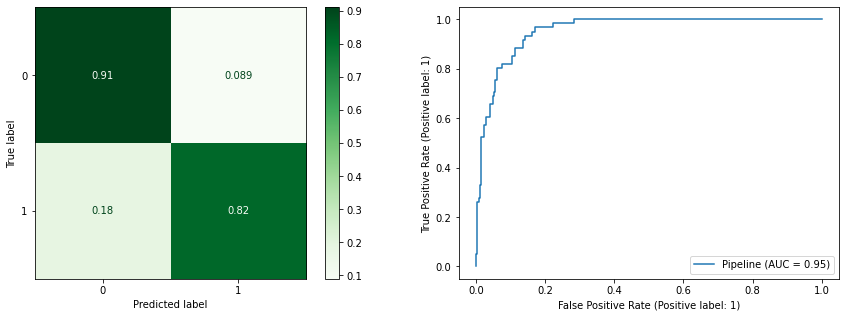

In [54]:
evaluate_classification(best_lr_model, X_test, y_test, label='Testing Data')

The tuned Logistic Regression model did much better on the recall score for teams that make the playoffs, improving the score from 0.69 to 0.85, a massive improvement. While the score was much improved, it is not as high as I would like it. I need to try another model on the data to try to improve the score.

##Model #2: Random Forest

All preprocessing steps have already been completed, so they do not need to be repeated in the successive models.

In [55]:
# Instantiate the model
rf = RandomForestClassifier()
# Make a pipeline with the model and preprocessor
rf_pipe = make_pipeline(preprocessor, rf)
# Fit the pipeline on the training data
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fcef0d71c40>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fcef0d71280>)])),
                ('randomforestclassifier', RandomForestClassifier())])

###Metric Evalution of the Model

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Testing Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       247
           1       0.79      0.72      0.75        61

    accuracy                           0.91       308
   macro avg       0.86      0.84      0.85       308
weighted avg       0.90      0.91      0.90       308



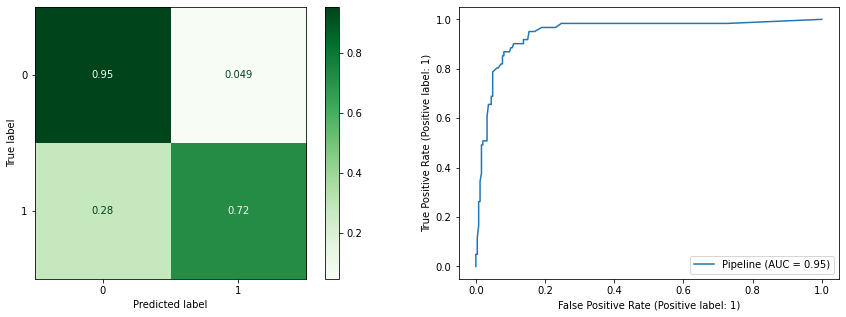

In [56]:
evaluate_classification(rf_pipe, X_test, y_test, label='Testing Data')

Right off the bat the Random Forest Model without tuning had a better recall score than Logistic Regression. The precision was also much higher, although I'm not prioritizing that as much as the recall score. Another note was that the accuracy was also higher, even if that doesn't give a good indication of the model performance.

###Implementing SMOTE

In [57]:
# Creating a model pipeline with SMOTE, the model, and preprocessor
smote = SMOTE()
rf_smote = RandomForestClassifier()
rf_smote_pipe = make_sampler_pipeline(preprocessor, smote, rf_smote)
# Fit the model on the training data
rf_smote_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fcef0d71c40>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fcef0d71280>)])),
                ('smote', SMOTE()),
                ('randomforestclassifier', RandomForestClassifier())])

###SMOTE Model Metric Evaluation

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Testing Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       247
           1       0.72      0.77      0.75        61

    accuracy                           0.90       308
   macro avg       0.83      0.85      0.84       308
weighted avg       0.90      0.90      0.90       308



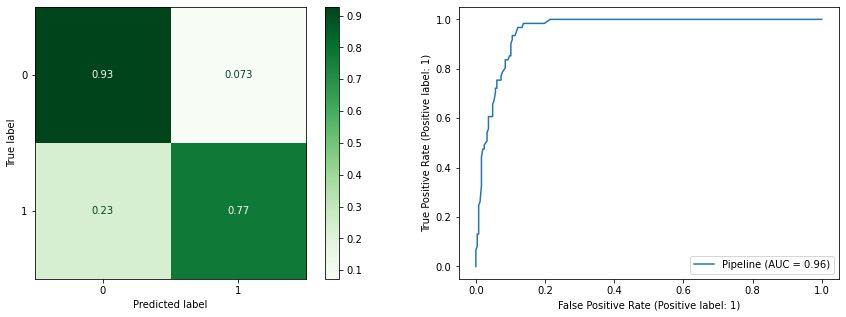

In [58]:
evaluate_classification(rf_smote_pipe, X_test, y_test, label='Testing Data')

SMOTE again helped with the recall score, improving it from 0.75 to 0.83. With some fine tuning, I should be able to improve the score.

###Parameter Tuning of the Model

In [59]:
# Find the tunable parameters of the model
rf_smote_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fcef0d71c40>),
                                   ('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fcef0d71280>)])),
  ('smote', SMOTE()),
  ('randomforestclassifier', RandomForestClassifier())],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fcef0d71c40>),
            

In [60]:
# Tuning various paremeters
param_grid2 = {'randomforestclassifier__n_jobs': [None,1,2],
               'randomforestclassifier__max_depth': [15,30,40],
               'randomforestclassifier__n_estimators': [200,300,400,500]}

In [61]:
# Make the grid search pipeline
dt_grid_search2 = GridSearchCV(rf_smote_pipe, param_grid2)

In [62]:
# Fit the pipeline on the training data
dt_grid_search2.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fcef0d71c40>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fcef0d71280>)])),
                                       ('smote', SMOTE()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             param_grid={'randomforestclassifier__max_depth': [15, 30, 40],
                         'randomforestclassifier__n_estimators': [200, 300, 400,
                                                                  500],
                         'randomforestclassifier__n_jobs': [None, 1, 2]})

In [63]:
# Finding the best tuned parameters
dt_grid_search2.best_params_

{'randomforestclassifier__max_depth': 30,
 'randomforestclassifier__n_estimators': 200,
 'randomforestclassifier__n_jobs': None}

In [64]:
# Instantiate the tuned model
best_rf_model = dt_grid_search2.best_estimator_
# Fit the model on the training data
best_rf_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fcef09dbf40>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fcef00e0a00>)])),
                ('smote', SMOTE()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=30, n_estimators=200))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Testing Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       247
           1       0.73      0.79      0.76        61

    accuracy                           0.90       308
   macro avg       0.84      0.86      0.85       308
weighted avg       0.90      0.90      0.90       308



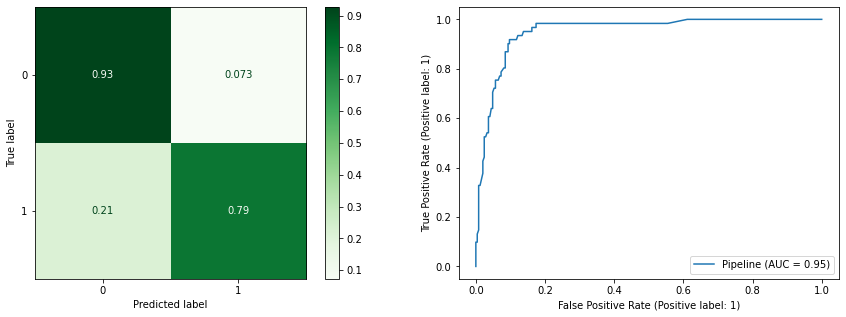

In [65]:
evaluate_classification(best_rf_model, X_test, y_test, label='Testing Data')

Tuning the Random Forest model with SMOTE has not been able to improve the recall score for the dataset. The recall score stayed the same, even for teams that do not make the playoffs. Due to this, I do not think this model would work best for predicting playoff teams with this dataset. I want to move on to XGBoost and see if that model can better predict playoff teams with some tuning.

##Model #3: XGBoost

In [66]:
# Instantiate the model
xgb = XGBClassifier()
# Make a pipeline with the model and preprocessor
xgb_pipe = make_pipeline(preprocessor, xgb)
# Fit the pipeline on the training data
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fcef0d71c40>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fcef0d71280>)])),
                ('xgbclassifier', XGBClassifier())])

###Metric Evaluation of the Model

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Testing Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       247
           1       0.78      0.80      0.79        61

    accuracy                           0.92       308
   macro avg       0.86      0.87      0.87       308
weighted avg       0.92      0.92      0.92       308



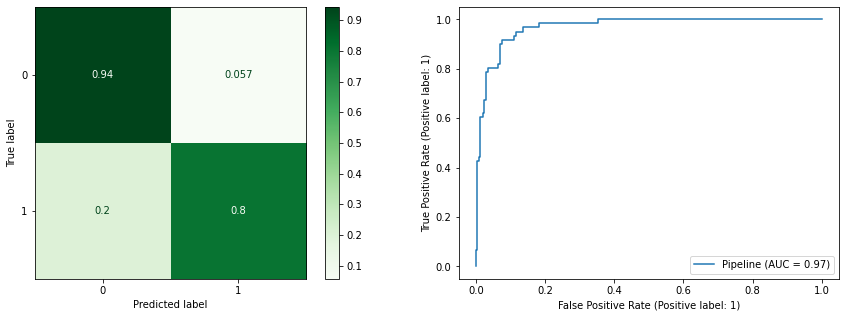

In [67]:
evaluate_classification(xgb_pipe, X_test, y_test, label='Testing Data')

XGBoost seems to have to best recall score of all the models that have not been tuned. Tuning the model should yield better scores, so I am going to tune it now to see if that is the case.

###Implementing SMOTE

In [68]:
# Creating a model pipeline with SMOTE, the model, and preprocessor
smote = SMOTE()
xgb_smote = XGBClassifier()
xgb_smote_pipe = make_sampler_pipeline(preprocessor, smote, xgb_smote)
# Fit the model on the training data
xgb_smote_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fcef0d71c40>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fcef0d71280>)])),
                ('smote', SMOTE()), ('xgbclassifier', XGBClassifier())])

###SMOTE Metric Evaluation

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Testing Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       247
           1       0.72      0.89      0.79        61

    accuracy                           0.91       308
   macro avg       0.84      0.90      0.87       308
weighted avg       0.92      0.91      0.91       308



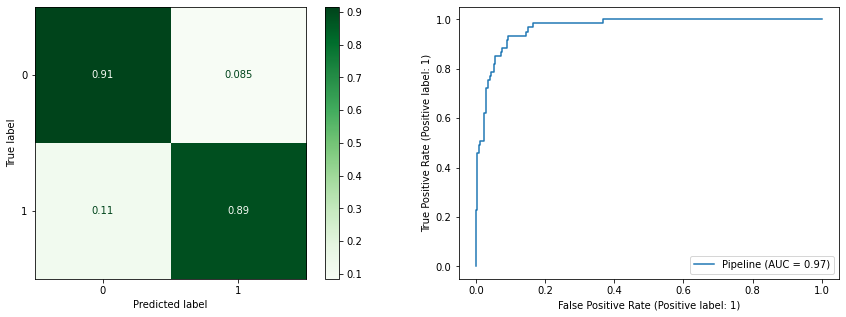

In [69]:
evaluate_classification(xgb_smote_pipe, X_test, y_test, label='Testing Data')

###Parameter Tuning of the Model

In [70]:
xgb_smote_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fcef0d71c40>),
                                   ('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fcef0d71280>)])),
  ('smote', SMOTE()),
  ('xgbclassifier', XGBClassifier())],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fcef0d71c40>),
                              

In [71]:
param_grid3 = {'xgbclassifier__n_estimators': [100,200,300,400,500],
               'xgbclassifier__max_depth': [3,7,11,14,17]}

In [72]:
# Make the grid search pipeline
dt_grid_search3 = GridSearchCV(xgb_smote_pipe, param_grid3)

In [73]:
# Fit the pipeline on the training data
dt_grid_search3.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fcef0d71c40>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fcef0d71280>)])),
                                       ('smote', SMOTE()),
                                       ('xgbclassifier', XGBClassifier())]),
             param_grid={'xgbclassifier__max_depth': [3, 7, 11, 14, 17],
                         'xgbclassifier__n_estimators': [100, 200, 300, 400,
                                                         500]})

In [74]:
# Finding the best tuned parameters
dt_grid_search3.best_params_

{'xgbclassifier__max_depth': 17, 'xgbclassifier__n_estimators': 100}

In [75]:
# Instantiate the tuned model
best_xgb_model = dt_grid_search3.best_estimator_
# Fit the model on the training data
best_xgb_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fceefeecd60>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fceefeecf40>)])),
                ('smote', SMOTE()),
                ('xgbclassifier', XGBClassifier(max_depth=17))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Testing Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       247
           1       0.74      0.85      0.79        61

    accuracy                           0.91       308
   macro avg       0.85      0.89      0.87       308
weighted avg       0.92      0.91      0.91       308



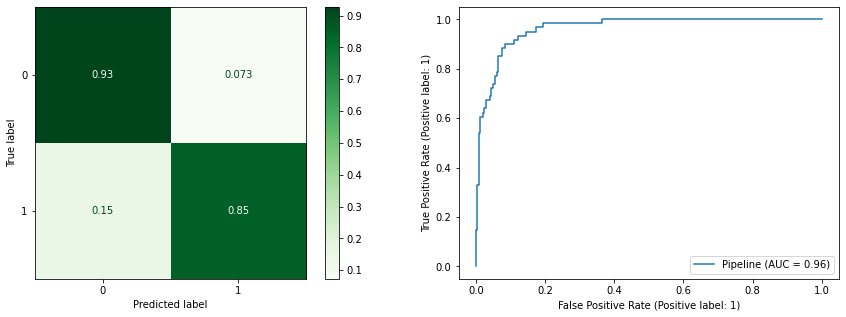

In [76]:
evaluate_classification(best_xgb_model, X_test, y_test, label='Testing Data')

#Feature Engineering

Now that I have implemented different models on the dataset and tuned them in order to find the most optimal for the dataset, I want to try some feature engineering to see if I can further improve the recall score of the model. The model that I will choose to instantiate with the engineered dataset will be the Logisitic Regression model used with SMOTE.

In [77]:
# Make another copy of the dataset
fe_df = df.copy()

##Creating a New Column

In the dataset, there are 2 rows that can be combined into one to form a new stat: OBP and SLG. In the vast statistical landscape of baseball, those 2 stats are combined and called OPS, or on-base plus slugging percentage. The 2 stats combined can give a clearer picture of overall production, as opposed to OBP and SLG separately.

In [78]:
fe_df['OPS'] = fe_df['OBP'] + fe_df['SLG']
fe_df = fe_df.drop(columns=['OBP', 'SLG'])
fe_df.head()

,Team,League,Year,RS,RA,W,BA,Playoffs,G,OOBP,OSLG,OPS
0,ARI,NL,2012,734,688,81,0.259,0,162,0.317,0.415,0.746
1,ATL,NL,2012,700,600,94,0.247,1,162,0.306,0.378,0.709
2,BAL,AL,2012,712,705,93,0.247,1,162,0.315,0.403,0.728
3,BOS,AL,2012,734,806,69,0.260,0,162,0.331,0.428,0.730
4,CHC,NL,2012,613,759,61,0.240,0,162,0.335,0.424,0.680


For the sake of consistency, I will also drop the 'OOBP' and 'OSLG' columns as well.

In [79]:
fe_df = fe_df.drop(columns=['OOBP', 'OSLG'])

Another piece of feature engineering that I will add to the dataset will be the run differential, which is the difference of the runs scored and runs allowed ('RS' and 'RA'). The difference when I add this statistical column from adding OPS is that I will not be dropping the runs scored and runs allowed column, as I feel they still add value to the model's ability to predict playoff teams.

In [80]:
fe_df['Run_differential'] = fe_df['RS'] - fe_df['RA']
fe_df.head()

,Team,League,Year,RS,RA,W,BA,Playoffs,G,OPS,Run_differential
0,ARI,NL,2012,734,688,81,0.259,0,162,0.746,46
1,ATL,NL,2012,700,600,94,0.247,1,162,0.709,100
2,BAL,AL,2012,712,705,93,0.247,1,162,0.728,7
3,BOS,AL,2012,734,806,69,0.260,0,162,0.730,-72
4,CHC,NL,2012,613,759,61,0.240,0,162,0.680,-146


Now that I have those features engineered in the dataset, now I can move on to preprocessing and getting the data ready for model validation.

##Preprocessing

###Train Test Split

In [81]:
# Assign features and target of the dataset
X = fe_df.drop(columns='Playoffs')
y = fe_df['Playoffs']
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

###Creating the Preprocessor Object

In [106]:
# Instantiate the transformers
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
# Create ColumnSelectors for the the numeric and categorical data
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')
# Combine the Pipelines and ColumnSelectors into tuples for the ColumnTransformer
cat_tuple = (ohe, cat_selector)
num_tuple = (scaler, num_selector)
# Create the preprocessing ColumnTransformer
fe_preprocessor = make_column_transformer(cat_tuple, num_tuple, remainder='drop')
fe_preprocessor

ColumnTransformer(transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fceeff425e0>),
                                ('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fceeff42130>)])

###Instantiate and Fit SMOTE Logistic Regression Model

In [107]:
# Creating a model pipeline with SMOTE, the model, and preprocessor
smote = SMOTE()
fe_lr_smote = LogisticRegression()
fe_lr_smote_pipe = make_sampler_pipeline(fe_preprocessor, smote, fe_lr_smote)
# Fit the model on the training data
fe_lr_smote_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fceeff425e0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fceeff42130>)])),
                ('smote', SMOTE()),
                ('logisticregression', LogisticRegression())])

###Metric Evaluation of the Model

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Testing Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.90      0.94       247
           1       0.69      0.89      0.78        61

    accuracy                           0.90       308
   macro avg       0.83      0.89      0.86       308
weighted avg       0.91      0.90      0.90       308



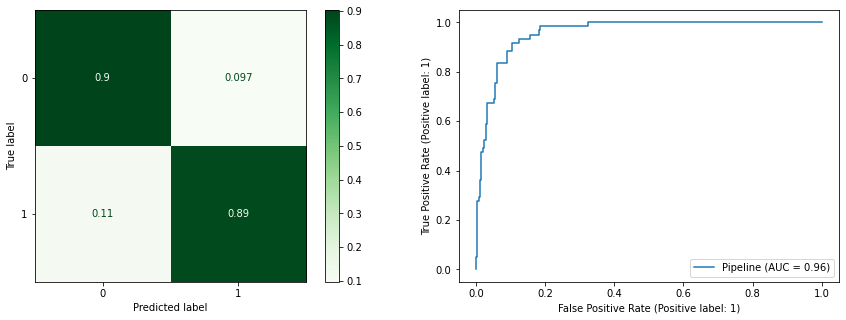

In [84]:
evaluate_classification(fe_lr_smote_pipe, X_test, y_test, label='Testing Data')

The model with engineered features did not end up producing a better recall score for the dataset.

#Evaluation and Final Model

After modeling the dataset with Logisitic Regression, Random Forest, and XGBoost, while also tuning the parameters and implementing SMOTE to address the class imbalance, I have determined that the best model to use for predicting if a team will make the playoffs is **Logistic Regression Model with SMOTE to correct class imbalance**. Recall score was my goal to improve throughout the modeling process, as I wanted to correctly identify the teams that make the playoffs, as opposed to the teams that did not. Feature engineering did not end up improving this model with combining a couple different columns in order to produce statistics that are also tracked in Major League Baseball. I also used SMOTE in order to correct for the large class imbalance of the target because the dataset was not able to have balanced number of teams that did and did not make the playoffs. The recall score of 0.90, giving the model the ability to predict a playoff team 90% of the time, is a good performing model, although it may not be an extremely optimal model with a 10% chance of incorrectly identifying a playoff team. 

With the volatility of baseball stats and components of a baseball game that simply cannot be covered by them alone, I feel confident in a 90% chance of preditcing a playoff team. Hall of Fame players are inducted having failed 70% of their professional lives, so 90% gives me reason to be optimistic.